## Setup Simulation

Import needed libraries and define constants

In [1]:
# Set plotting in separate window
#%matplotlib qt
# Imports
from rcfdtd_sim import Sim, Current, Mat, vis
import numpy as np
from scipy.fftpack import fft, fftfreq
from matplotlib import pyplot as plt
from pathlib import Path
# Determine file save name
fsave = 'thin_mat_oscillate_v3.npz'
# Constants
c0 = 1 # um/ps
di = 0.003 # 0.003 um
dn = di/c0 # (0.003 um) / (300 um/ps) = 0.00001 ps = 0.01 fs
epsilon0 = 1
mu0 = 1

Define simulation bounds and calculate length in indicies

In [2]:
# Define bounds
i0 = -5 # -5 um
i1 = 5 # 5 um
n0 = -90 # (0.01 fs) * (-90 um) / (0.003 um/step) = (0.01 fs) * (-30,000 steps) = -300 fs
n1 = 420 # (0.01 fs) * (420 um) / (0.003 um/step) = (0.01 fs) * (140,000 steps) = 1.4 ps
# Calculate dimensions
nlen, ilen = Sim.calc_dims(n0, n1, dn, i0, i1, di)

In [3]:
print(nlen, ilen)

170000 3335


Create our time and space arrays to help construct our material and current pulse

In [4]:
# Create a arrays that hold the value of the center of each cell
t = np.linspace(n0+dn/2, n1+dn/2, nlen, endpoint=False) * (10/3) # Multiply by 10/3 to get from um -> fs
z = np.linspace(i0+di/2, i1+di/2, ilen, endpoint=False)

## Setup Current

Specify the location of our current pulse in time and space

In [5]:
cp_loc_val = -3 # -3 um
cp_time_val = 0 # 0 fs

Determine the simulation indicies that correspond to these locations

In [6]:
# Find indicies
cp_loc_ind = np.argmin(np.abs(np.subtract(z, cp_loc_val)))
cp_time_ind = np.argmin(np.abs(np.subtract(t, cp_time_val)))
# Find start and end indicies in time
spread = int(250 / 0.01) # (250 fs) / (0.01 fs/step) = 25,000 steps
cp_time_s = cp_time_ind - spread
cp_time_e = cp_time_ind + spread

Create the current pulse

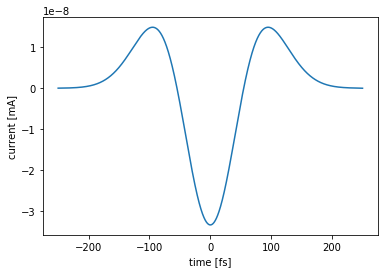

In [7]:
# Make pulse
cpulse = np.append(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(6e3)))), [0,0])
#cpulse = np.append(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(6e3))), [0])
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)

## Setup Material

Specify the location of our material (which will be $0.09$um in length)

In [8]:
# Set material length
m_len = 0.09 # 0.09 um
# Set locations
m_s_val = 0
m_e_val = m_s_val + m_len

Calculate the starting and ending indicies of our material

In [9]:
m_s_ind = np.argmin(np.abs(np.subtract(z, m_s_val)))
m_e_ind = np.argmin(np.abs(np.subtract(z, m_e_val)))

Setup material behavior

In [10]:
# Set constants
a = np.complex64(1)
gamma = np.complex64(0.01)
freq = np.complex64(1)
# Calculate beta
ang_gamma = np.complex64(gamma * 2 * np.pi)
omega = np.complex64(freq * 2 * np.pi)
beta = np.sqrt(np.add(np.square(ang_gamma), -np.square(omega)), dtype=np.complex64)
a1 = np.complex64(a/(2*beta))
a2 = np.complex64(-a/(2*beta))

In [11]:
print(gamma, beta, a1, a2)

(0.01+0j) 6.2828712j -0.07958145j (-0+0.07958145j)


Create our material behavior matrices

In [12]:
# Determine matrix length
mlen = m_e_ind - m_s_ind
# Create matrices
m = np.ones((1, mlen), dtype=np.complex64)
mgamma = m * ang_gamma
mbeta = m * beta
ma1 = m * a1
ma2 = m * a2

Create our material object

In [13]:
inf_perm = 16
material = Mat(dn, ilen, nlen, m_s_ind, inf_perm, ma1, ma2, mgamma, mbeta, storelocs=[1])

## Running the Simulation

Create and run our simulation (or load simulation if one already exists)

In [14]:
# Create Sim object
s = Sim(i0, i1, di, n0, n1, dn, epsilon0, mu0, 'absorbing', current, material, nstore=int(nlen/40), storelocs=[5,ilen-6])
# Run simulation if simulation save doesn't exist
sim_file = Path(fsave)
if sim_file.is_file():
    # Load results
    dat = np.load(fsave)
    n = dat['n']
    ls = dat['ls']
    els = dat['els']
    erls = dat['erls']
    hls = dat['hls']
    hrls = dat['hrls']
    chi = dat['chi']
else:
    # Run simulation
    s.simulate()
    # Export visualization
    #vis.timeseries(s, iunit='um')#, fname=fsave+'.mp4')
    # Export and save arrays
    n, ls, els, erls, hls, hrls = s.export_locs()
    ls_mat, chi = material.export_locs()
    n = n * (10/3) # 10/3 scale factor converts from um -> fs
    #np.savez(fsave, n=n, ls=ls, els=els, erls=erls, hls=hls, hrls=hrls, chi=chi)

Executing simulation: 100%|██████████| 170000/170000 [01:21<00:00, 2079.28it/s]


## Looking at $\chi$

We look at the value of $\chi$ in time

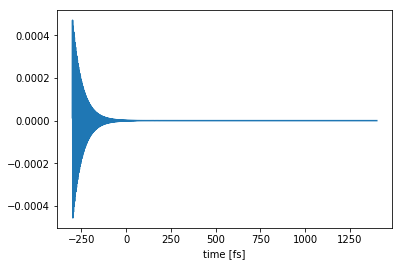

In [15]:
# Plot
plt.plot(n, np.real(chi))
plt.xlabel('time [fs]')
plt.show()

## Finding the Transmission and Reflection Coefficients

### Finding the Incident, Transmitted, and Reflected Fields

We ultimately wish to calculate the reflection and transmission coefficients
$$R(\omega)=\frac{E_r(\omega)}{E_i(\omega)} \qquad T(\omega)=\frac{E_t(\omega)}{E_i(\omega)}$$
which means that we need to extract our incident E-field $E_i$, reflected E-field $E_r$, and transmitted E-field $E_t$ from our E-field and reference E-field passing through $i=5$ and $i=\text{ilen}-6$ (these fields are contained in `els` and `erls`). The incident E-field $E_i$ should be equal to the reference E-field passing through $i=\text{ilen}-6$. Since the current is only non-zero from $-20$fs to $20$fs and since it will take light propegating at $300$um/ps $27$fs to reach the end of the simulation at $5.09$um from $-3$um, we plot the reference E-field from $7$fs to $47$fs below

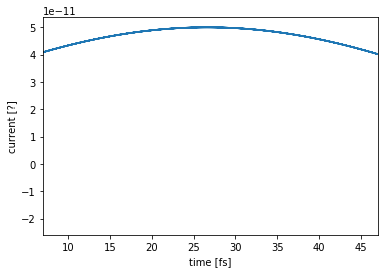

In [16]:
# Plot the E-field passing through i=ilen-2
inc = erls[:,1] # Extract the transmitted reference E-field as the incident field
plt.plot(n, np.real(inc))
plt.ylabel('current [?]')
plt.xlabel('time [fs]')
# Lets zoom in on the x-axis as described above
plt.xlim(7, 47)
plt.show()

The pulse is (roughly) centered as expected. We can extract $E_i(\omega)$ from $E^{i=\text{ilen}-2}_\text{ref}(t)$ via
$$\mathcal{F}\left\{E^{i=\text{ilen}-2}_\text{ref}(t)\right\}=E_i(\omega)$$
where $\mathcal{F}\left\{A(t)\right\}=A(\omega)$ denotes a Fourier Transform on $A$

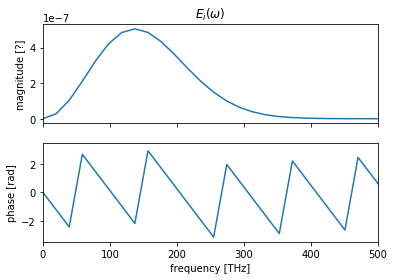

In [17]:
# Perform FFT
incf = fft(inc)
# Determine the frequency that each value in eef corresponds to
nf = fftfreq(nlen, dn) * 1e4 #  # Mulitply by 1e4 to go from units of 1e16 Hz -> 1e14 Hz which is THz
# Discard negative frequencies (at nlen/2 and above), keep DC (at 0)
incf = incf[0:int(nlen/2)]
nf = nf[0:int(nlen/2)]
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(nf, np.absolute(incf))
ax0.set_title('$E_i(\omega)$')
ax0.set_ylabel('magnitude [?]')
ax1.plot(nf, np.angle(incf))
ax1.set_ylabel('phase [rad]')
plt.xlabel('frequency [THz]')
plt.xlim(0, 500) # Truncate at 6000THz
plt.show()

We can determine the transmitted E-field $E_t$ from the E-field passing through $i=\text{ilen}-2$. We plot this field below

In [18]:
# Extract the E-field as the transmitted field
trans = els[:,1]

Since there will be an infinite number of reflections inside of the material, we will never capture the entire transmitted E-field. However, if we run the simulation for a long enough time the E-field remaining in the material will become negligable. We extract $E_t(\omega)$ via
$$\mathcal{F}\left\{E^{i=\text{ilen}-2}(t)\right\}=E_t(\omega)$$
where again $\mathcal{F}\left\{A(t)\right\}=A(\omega)$ denotes a Fourier Transform on $A$

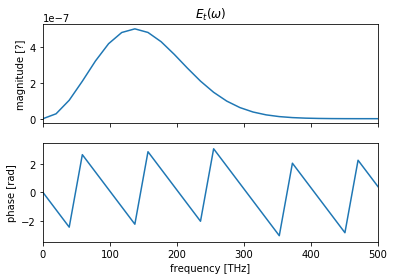

In [19]:
# Perform FFT
transf = fft(trans)
# Discard negative frequencies (at nlen/2 and above), keep DC (at 0)
transf = transf[0:int(nlen/2)]
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(nf, np.absolute(transf))
ax0.set_title('$E_t(\omega)$')
ax0.set_ylabel('magnitude [?]')
ax1.plot(nf, np.angle(transf))
ax1.set_ylabel('phase [rad]')
plt.xlabel('frequency [THz]')
plt.xlim(0, 500) # Truncate at 6000THz
plt.show()

Now all that remains is to determine the reflected E-field $E_r(\omega)$. This field is slightly harder to calculate than $E_i$ and $E_t$ as the current pulse that generates the EM pulse in the simulation actually produces two EM pulses, one traveling towards each end of the simulation. The forward propegating pulse is our incident pulse (we used this to calculate $E_i(\omega)$ previously), while the backward propegating pulse is unwanted. Since the reference field never interacts with a material, $E^{i=1}_\text{ref}(t)$ will only contain the backward propegating pulse. As such, we can determine the reflected field $E_r(t)$ from
$$E_r(t)=E^{i=1}(t)-E^{i=1}_\text{ref}(t)$$
As in the case of determining the transmitted field $E_t$ we can never capture the entire transmitted E-field as there will be an infinite number of reflections inside the material. However, as before, if we run the simulation for a long enough time the E-field remaining in the material will become negligable.

In [20]:
# Plot the reflected E-field passing through i=1
r = els[:,0] # Extract the transmitted E-field
rref = erls[:,0]
refl = r - rref

We extract $E_t(\omega)$ via a Fourier transform as usual
$$\mathcal{F}\left\{E_r(t)\right\}=E_r(\omega)$$
where again $\mathcal{F}\left\{A(t)\right\}=A(\omega)$ denotes a Fourier Transform on $A$

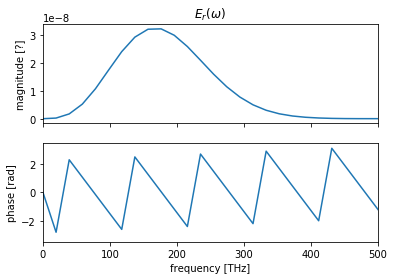

In [21]:
# Perform FFT
reflf = fft(refl)
# Discard negative frequencies (at nlen/2 and above), keep DC (at 0)
reflf = reflf[0:int(nlen/2)]
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(nf, np.absolute(reflf))
ax0.set_title('$E_r(\omega)$')
ax0.set_ylabel('magnitude [?]')
ax1.plot(nf, np.angle(reflf))
ax1.set_ylabel('phase [rad]')
plt.xlabel('frequency [THz]')
plt.xlim(0, 500) # Truncate at 6000THz
plt.show()

We plot $E_i(t)$, $E_t(t)$, and $E_r(t)$ together

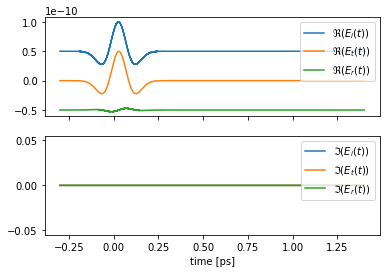

In [22]:
# Calculate offset
rofst = np.max(np.abs(np.real([inc, trans, refl])))
iofst = np.max(np.abs(np.imag([inc, trans, refl])))
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(n * 1e-3, np.real(inc)+rofst, label='$\Re(E_i(t))$') # 1e-3 scale factor converts from fs -> ps
ax0.plot(n * 1e-3, np.real(trans), label='$\Re(E_t(t))$') # 1e-3 scale factor converts from fs -> ps
ax0.plot(n * 1e-3, np.real(refl)-rofst, label='$\Re(E_r(t))$') # 1e-3 scale factor converts from fs -> ps
ax1.plot(n * 1e-3, np.imag(inc)+iofst, label='$\Im(E_i(t))$') # 1e-3 scale factor converts from fs -> ps
ax1.plot(n * 1e-3, np.imag(trans), label='$\Im(E_t(t))$') # 1e-3 scale factor converts from fs -> ps
ax1.plot(n * 1e-3, np.imag(refl)-iofst, label='$\Im(E_r(t))$') # 1e-3 scale factor converts from fs -> ps
ax0.legend(loc=1)
ax1.legend(loc=1)
ax1.set_xlabel('time [ps]')
plt.show()

### Finding the Reflection and Transmission Coefficients

We can now finally calculate
$$R(\omega)=\left(\frac{E_r(\omega)}{E_i(\omega)}\right)^2 \qquad T(\omega)=\left(\frac{E_t(\omega)}{E_i(\omega)}\right)^2$$

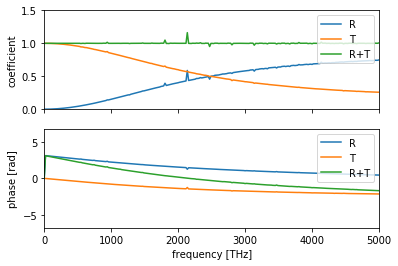

In [23]:
# Calculate coefficients
R = np.square(np.divide(reflf, incf))
T = np.square(np.divide(transf, incf))
# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(nf, np.absolute(R), label='R')
ax0.plot(nf, np.absolute(T), label='T')
ax0.plot(nf, np.absolute(R)+np.absolute(T), label='R+T')
ax0.legend(loc=1)
ax0.set_ylabel('coefficient')
ax0.set_ylim(0, 1.5)
ax1.plot(nf, np.angle(R), label='R')
ax1.plot(nf, np.angle(T), label='T')
ax1.plot(nf, np.angle(R)+np.angle(T), label='R+T')
ax1.legend(loc=1)
ax1.set_ylabel('phase [rad]')
ax1.set_xlabel('frequency [THz]')
ax1.set_xlim(0, 5000) # Truncate at 6000THz, otherwise signal-to-noise becomes unweildy
plt.show()

There is a clear Fabry-Perot effect present in the material transmission. Notably $R(\omega)+T(\omega)\neq1$, which suggests values are being incorrectly normalized somewhere in the simulation. Hopefully further investigation will determine the cause of this issue.